# Time Series Data

- Time Series Data
- Apply RNN
    - Many to One
    - Data Reading
    - Neural Net Setting
    - Training & Evaluation
- Exercise

time series data : 시계열 데이터,  
일정한 시간간격으로 배치된 데이터를 말합니다.  
ex) 주가 데이터

제 github Repositories에서 다루었던 내용입니다. 거기선 rnn을 사용한것은 아님,,

![](img/20191222_231412.png)

이모델은 8일째의 종가를 예측하기 위해서 그 전주의 기록을 보면될것이라는 전재를 가지고 만들어지는 모델입니다.  (물론 99퍼 틀림)  

이 모델은 (Open, High, Low, Volume, Close)의 5개의 dimension을 가진 Vector가 첫날 input으로 들어가게 됩니다.   
이 정보는 첫번째 셀에 들어가 어떠한 벡터 (hidden state)를 만들어냅니다 그다음,  둘째날 input과 결합되어 다음 값과 연속적으로 값을 만들어 냅니다.   
이렇게 7개의 셀을 통과한후 8일째 종가를 예측하게 됩니다.  

만약 output이 종가를 딱 예측하게 된다면 Output의 dimension은 1이 되게 됩니다.  
각셀에서 크기가 5인 Vector들을 받아 하나의 dimension으로 압축하여 정보를 전달하기는 쉬운일이 아닙니다.  

그래서 실제로는 data를 유통시키기 위해 hidden state의 dimension을 충분히 보장해주고 보장된 hiddenstate 들이 유통이 되어 마지막 출력시 마지막 output(종가)가 충분히큰(ex 10개)의 벡터를 가지고 FC를 거쳐 최종종가를 맞추는것이 일반적인 방법입니다.  

### Apply RNN : Data Reading

In [7]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

In [4]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

## Linear하게 최소값 최대값을 그어 나누어 주는 방식을 취합니다.

In [5]:
# make dataset to input
# Lable과 학습대상을 나누어줍니다.
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)


In [6]:
# hyper parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [10]:
# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data 
# 주가 데이터는 800 개 정도 였고
# 거래량같은 경우 1000000 정도 크기의 였습니다.
# 이러한 값들을 0~1사이의 상대값으로 바꿔줍니다.

train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

 [0.11199043 0.12574072 0.13002235 0.17008156 0.13659745]] -> [0.12455713]
[[0.12220255 0.12138537 0.12372168 0.16807385 0.11480508]
 [0.09611997 0.09773711 0.09973633 0.18754145 0.08319064]
 [0.07773084 0.07698102 0.05455784 0.29825222 0.08660558]
 [0.0767648  0.11393376 0.1029582  0.24120283 0.12374741]
 [0.11368095 0.10896575 0.12515372 0.15624272 0.12008597]
 [0.11199043 0.12574072 0.13002235 0.17008156 0.13659745]
 [0.13493355 0.12938155 0.13621566 0.15063189 0.12455713]] -> [0.1241346]
[[0.09611997 0.09773711 0.09973633 0.18754145 0.08319064]
 [0.07773084 0.07698102 0.05455784 0.29825222 0.08660558]
 [0.0767648  0.11393376 0.1029582  0.24120283 0.12374741]
 [0.11368095 0.10896575 0.12515372 0.15624272 0.12008597]
 [0.11199043 0.12574072 0.13002235 0.17008156 0.13659745]
 [0.13493355 0.12938155 0.13621566 0.15063189 0.12455713]
 [0.10408962 0.11202828 0.12085782 0.09108183 0.1241346 ]] -> [0.07952921]
[[0.07773084 0.07698102 0.05455784 0.29825222 0.08660558]
 [0.0767648  0.1139337

 [0.22822425 0.22244355 0.24468696 0.15803531 0.23707395]] -> [0.21609131]
[[0.16036071 0.17565744 0.19052296 0.1441158  0.18486407]
 [0.18150985 0.19620923 0.20097623 0.17246572 0.21176107]
 [0.21166373 0.23826577 0.23910232 0.18788205 0.25840845]
 [0.24123123 0.2445266  0.26290866 0.1473604  0.24337573]
 [0.23702205 0.23146036 0.25471058 0.12065968 0.23774277]
 [0.22822425 0.22244355 0.24468696 0.15803531 0.23707395]
 [0.22787922 0.22091228 0.20824335 0.12791073 0.21609131]] -> [0.18444154]
[[0.18150985 0.19620923 0.20097623 0.17246572 0.21176107]
 [0.21166373 0.23826577 0.23910232 0.18788205 0.25840845]
 [0.24123123 0.2445266  0.26290866 0.1473604  0.24337573]
 [0.23702205 0.23146036 0.25471058 0.12065968 0.23774277]
 [0.22822425 0.22244355 0.24468696 0.15803531 0.23707395]
 [0.22787922 0.22091228 0.20824335 0.12791073 0.21609131]
 [0.19437874 0.19178579 0.19685934 0.16659496 0.18444154]] -> [0.18345577]
[[0.21166373 0.23826577 0.23910232 0.18788205 0.25840845]
 [0.24123123 0.244526

 [0.28473691 0.28546025 0.30873152 0.19978489 0.29815549]] -> [0.29125515]
[[0.21459647 0.20961555 0.22493288 0.40337008 0.22464623]
 [0.2087312  0.23486317 0.23874431 0.13703505 0.25488793]
 [0.24337024 0.26087965 0.26294437 0.19711392 0.25372613]
 [0.2436118  0.28576638 0.27801585 0.17579995 0.30311943]
 [0.2979164  0.29423904 0.30175077 0.15541812 0.29378991]
 [0.28473691 0.28546025 0.30873152 0.19978489 0.29815549]
 [0.28984307 0.28443941 0.3121324  0.11703863 0.29125515]] -> [0.31727197]
[[0.2087312  0.23486317 0.23874431 0.13703505 0.25488793]
 [0.24337024 0.26087965 0.26294437 0.19711392 0.25372613]
 [0.2436118  0.28576638 0.27801585 0.17579995 0.30311943]
 [0.2979164  0.29423904 0.30175077 0.15541812 0.29378991]
 [0.28473691 0.28546025 0.30873152 0.19978489 0.29815549]
 [0.28984307 0.28443941 0.3121324  0.11703863 0.29125515]
 [0.2886701  0.3008741  0.31893437 0.12906695 0.31727197]] -> [0.31609272]
[[0.24337024 0.26087965 0.26294437 0.19711392 0.25372613]
 [0.2436118  0.285766

 [0.32230868 0.32843538 0.34794237 0.08773864 0.34519007]] -> [0.32762237]
[[0.33500505 0.3349003  0.34966056 0.18411759 0.34121168]
 [0.3314513  0.35276421 0.36887412 0.15158197 0.35976514]
 [0.34011122 0.34663936 0.37567587 0.10981447 0.36413051]
 [0.35122054 0.35225378 0.37306244 0.09206776 0.35487145]
 [0.33034738 0.32625771 0.35609378 0.08286278 0.33962757]
 [0.32230868 0.32843538 0.34794237 0.08773864 0.34519007]
 [0.32465462 0.31890794 0.34351041 0.12027427 0.32762237]] -> [0.3339946]
[[0.3314513  0.35276421 0.36887412 0.15158197 0.35976514]
 [0.34011122 0.34663936 0.37567587 0.10981447 0.36413051]
 [0.35122054 0.35225378 0.37306244 0.09206776 0.35487145]
 [0.33034738 0.32625771 0.35609378 0.08286278 0.33962757]
 [0.32230868 0.32843538 0.34794237 0.08773864 0.34519007]
 [0.32465462 0.31890794 0.34351041 0.12027427 0.32762237]
 [0.31706442 0.31822758 0.34524656 0.09039168 0.3339946 ]] -> [0.27829953]
[[0.34011122 0.34663936 0.37567587 0.10981447 0.36413051]
 [0.35122054 0.3522537

 [0.31075065 0.30291557 0.32734716 0.12131397 0.30857635]] -> [0.30033818]
[[0.28104527 0.30124832 0.3166073  0.11438559 0.31547648]
 [0.31171669 0.31087781 0.34524656 0.08700367 0.33202308]
 [0.3147529  0.30870014 0.34012728 0.09221117 0.32367932]
 [0.30764561 0.30121438 0.335008   0.08128529 0.31973648]
 [0.30685209 0.30371858 0.33321817 0.07000986 0.31688477]
 [0.31075065 0.30291557 0.32734716 0.12131397 0.30857635]
 [0.29881339 0.29202721 0.31868372 0.14624899 0.30033818]] -> [0.27618709]
[[0.31171669 0.31087781 0.34524656 0.08700367 0.33202308]
 [0.3147529  0.30870014 0.34012728 0.09221117 0.32367932]
 [0.30764561 0.30121438 0.335008   0.08128529 0.31973648]
 [0.30685209 0.30371858 0.33321817 0.07000986 0.31688477]
 [0.31075065 0.30291557 0.32734716 0.12131397 0.30857635]
 [0.29881339 0.29202721 0.31868372 0.14624899 0.30033818]
 [0.28504752 0.28076463 0.29549655 0.15195841 0.27618709]] -> [0.2698502]
[[0.3147529  0.30870014 0.34012728 0.09221117 0.32367932]
 [0.30764561 0.3012143

 [0.31809951 0.30921056 0.33450692 0.13117325 0.31185038]] -> [0.33600125]
[[0.26948745 0.29100637 0.30465034 0.13197096 0.30769617]
 [0.29450074 0.31149027 0.32654153 0.1510173  0.32466509]
 [0.31861705 0.31836357 0.34882644 0.12876221 0.34050775]
 [0.33414248 0.34197789 0.36493623 0.33420274 0.36448258]
 [0.34214676 0.3333657  0.34331344 0.15072152 0.33381857]
 [0.31809951 0.30921056 0.33450692 0.13117325 0.31185038]
 [0.29950345 0.31866991 0.33278852 0.15418123 0.33600125]] -> [0.29048055]
[[0.29450074 0.31149027 0.32654153 0.1510173  0.32466509]
 [0.31861705 0.31836357 0.34882644 0.12876221 0.34050775]
 [0.33414248 0.34197789 0.36493623 0.33420274 0.36448258]
 [0.34214676 0.3333657  0.34331344 0.15072152 0.33381857]
 [0.31809951 0.30921056 0.33450692 0.13117325 0.31185038]
 [0.29950345 0.31866991 0.33278852 0.15418123 0.33600125]
 [0.32051449 0.31305548 0.31009191 0.17191001 0.29048055]] -> [0.29766251]
[[0.31861705 0.31836357 0.34882644 0.12876221 0.34050775]
 [0.33414248 0.341977

 [0.10536606 0.10484864 0.11294611 0.20868513 0.11966344]] -> [0.14138535]
[[0.15266704 0.17426238 0.1632798  0.19849422 0.15979768]
 [0.12544569 0.12529839 0.11004653 0.33265215 0.13195025]
 [0.08400998 0.11383151 0.09823286 0.33168414 0.11251682]
 [0.11247335 0.11910566 0.07507078 0.49577844 0.06555259]
 [0.05106156 0.0877334  0.07353138 0.2330017  0.09959632]
 [0.10536606 0.10484864 0.11294611 0.20868513 0.11966344]
 [0.12158155 0.14911679 0.1476356  0.26093932 0.14138535]] -> [0.18106193]
[[0.12544569 0.12529839 0.11004653 0.33265215 0.13195025]
 [0.08400998 0.11383151 0.09823286 0.33168414 0.11251682]
 [0.11247335 0.11910566 0.07507078 0.49577844 0.06555259]
 [0.05106156 0.0877334  0.07353138 0.2330017  0.09959632]
 [0.10536606 0.10484864 0.11294611 0.20868513 0.11966344]
 [0.12158155 0.14911679 0.1476356  0.26093932 0.14138535]
 [0.15411599 0.17436442 0.17287399 0.20981447 0.18106193]] -> [0.16627549]
[[0.08400998 0.11383151 0.09823286 0.33168414 0.11251682]
 [0.11247335 0.119105

 [0.14783686 0.15639847 0.16685968 0.17519943 0.14955307]] -> [0.15645319]
[[0.18575345 0.19042467 0.21028405 0.08582952 0.20327661]
 [0.19230878 0.18538877 0.20623858 0.10053778 0.19278529]
 [0.19027324 0.18314321 0.20018856 0.11933315 0.18599075]
 [0.17950894 0.17252703 0.1954273  0.11486959 0.18254047]
 [0.16881348 0.16269325 0.16646946 0.15399301 0.15476328]
 [0.14783686 0.15639847 0.16685968 0.17519943 0.14955307]
 [0.13921157 0.14380871 0.15221787 0.12407457 0.15645319]] -> [0.14884892]
[[0.19230878 0.18538877 0.20623858 0.10053778 0.19278529]
 [0.19027324 0.18314321 0.20018856 0.11933315 0.18599075]
 [0.17950894 0.17252703 0.1954273  0.11486959 0.18254047]
 [0.16881348 0.16269325 0.16646946 0.15399301 0.15476328]
 [0.14783686 0.15639847 0.16685968 0.17519943 0.14955307]
 [0.13921157 0.14380871 0.15221787 0.12407457 0.15645319]
 [0.12627385 0.13315859 0.15579775 0.13941024 0.14884892]] -> [0.15824868]
[[0.19027324 0.18314321 0.20018856 0.11933315 0.18599075]
 [0.17950894 0.172527

 [0.00810774 0.03751064 0.03311417 0.25770368 0.0434436 ]] -> [0.06530621]
[[0.1325874  0.13730964 0.13603665 0.15275612 0.11797353]
 [0.114371   0.12910937 0.14154965 0.14366765 0.12600055]
 [0.09957004 0.11066715 0.11133528 0.17805862 0.09192159]
 [0.09691349 0.09229303 0.09203955 0.25145648 0.07481176]
 [0.05834126 0.05809648 0.0051551  0.35460249 0.00999833]
 [0.00810774 0.03751064 0.03311417 0.25770368 0.0434436 ]
 [0.06313692 0.06088662 0.0613597  0.26161154 0.06530621]] -> [0.08378899]
[[0.114371   0.12910937 0.14154965 0.14366765 0.12600055]
 [0.09957004 0.11066715 0.11133528 0.17805862 0.09192159]
 [0.09691349 0.09229303 0.09203955 0.25145648 0.07481176]
 [0.05834126 0.05809648 0.0051551  0.35460249 0.00999833]
 [0.00810774 0.03751064 0.03311417 0.25770368 0.0434436 ]
 [0.06313692 0.06088662 0.0613597  0.26161154 0.06530621]
 [0.05816875 0.0739868  0.06927481 0.33004392 0.08378899]] -> [0.1137842]
[[0.09957004 0.11066715 0.11133528 0.17805862 0.09192159]
 [0.09691349 0.0922930

 [0.01849259 0.04155976 0.04453411 0.2052792  0.05467408]] -> [0.05051987]
[[0.0348806  0.03043316 0.02588276 0.18494219 0.01274435]
 [0.00100056 0.         0.         0.20783365 0.        ]
 [0.01445593 0.02383205 0.01729096 0.21175047 0.01277958]
 [0.         0.02468275 0.01947473 0.19786681 0.02929095]
 [0.03767514 0.03301921 0.03651515 0.24270861 0.03252986]
 [0.01849259 0.04155976 0.04453411 0.2052792  0.05467408]
 [0.05640918 0.05622504 0.0660708  0.1993457  0.05051987]] -> [0.08973891]
[[0.00100056 0.         0.         0.20783365 0.        ]
 [0.01445593 0.02383205 0.01729096 0.21175047 0.01277958]
 [0.         0.02468275 0.01947473 0.19786681 0.02929095]
 [0.03767514 0.03301921 0.03651515 0.24270861 0.03252986]
 [0.01849259 0.04155976 0.04453411 0.2052792  0.05467408]
 [0.05640918 0.05622504 0.0660708  0.1993457  0.05051987]
 [0.04347125 0.07929489 0.06672952 0.20263512 0.08973891]] -> [0.14729971]
[[0.01445593 0.02383205 0.01729096 0.21175047 0.01277958]
 [0.         0.024682

 [0.18002627 0.18382356 0.1916327  0.14420543 0.17704842]] -> [0.16599387]
[[0.11506085 0.12257635 0.13768341 0.11291566 0.12420506]
 [0.119546   0.14197132 0.14090528 0.1561262  0.15627716]
 [0.14024665 0.14452321 0.16402431 0.12277494 0.15286221]
 [0.14697429 0.1661981  0.16866025 0.14451017 0.17736537]
 [0.16801996 0.18351743 0.19893575 0.16961549 0.19877033]
 [0.18002627 0.18382356 0.1916327  0.14420543 0.17704842]
 [0.16129233 0.16847781 0.17881664 0.12952407 0.16599387]] -> [0.177154]
[[0.119546   0.14197132 0.14090528 0.1561262  0.15627716]
 [0.14024665 0.14452321 0.16402431 0.12277494 0.15286221]
 [0.14697429 0.1661981  0.16866025 0.14451017 0.17736537]
 [0.16801996 0.18351743 0.19893575 0.16961549 0.19877033]
 [0.18002627 0.18382356 0.1916327  0.14420543 0.17704842]
 [0.16129233 0.16847781 0.17881664 0.12952407 0.16599387]
 [0.14969988 0.16037959 0.18060648 0.08794479 0.177154  ]] -> [0.16335354]
[[0.14024665 0.14452321 0.16402431 0.12277494 0.15286221]
 [0.14697429 0.1661981 

 [0.19686278 0.1967536  0.21636978 0.16111858 0.2052128 ]] -> [0.23570078]
[[0.2401271  0.23435275 0.24046271 0.15993547 0.21989367]
 [0.20869678 0.21152104 0.22596396 0.16248095 0.20640994]
 [0.20307307 0.20549844 0.2251763  0.12384153 0.22165382]
 [0.20303844 0.21240568 0.20283771 0.15197634 0.19282063]
 [0.19424085 0.20713175 0.20921002 0.14636551 0.2181333 ]
 [0.19686278 0.1967536  0.21636978 0.16111858 0.2052128 ]
 [0.19958837 0.21710131 0.2127899  0.19060679 0.23570078]] -> [0.23038477]
[[0.20869678 0.21152104 0.22596396 0.16248095 0.20640994]
 [0.20307307 0.20549844 0.2251763  0.12384153 0.22165382]
 [0.20303844 0.21240568 0.20283771 0.15197634 0.19282063]
 [0.19424085 0.20713175 0.20921002 0.14636551 0.2181333 ]
 [0.19686278 0.1967536  0.21636978 0.16111858 0.2052128 ]
 [0.19958837 0.21710131 0.2127899  0.19060679 0.23570078]
 [0.22335965 0.22057201 0.24552831 0.10659676 0.23038477]] -> [0.23872853]
[[0.20307307 0.20549844 0.2251763  0.12384153 0.22165382]
 [0.20303844 0.212405

 [0.11747605 0.13186556 0.12765957 0.20712557 0.14075166]] -> [0.1452226]
[[0.15087306 0.16289754 0.18193115 0.10492068 0.17271818]
 [0.16001568 0.15643241 0.17158524 0.13891727 0.16979622]
 [0.16436296 0.15758945 0.17810062 0.12561621 0.16708521]
 [0.15097653 0.16361205 0.17810062 0.14675988 0.16412814]
 [0.14352421 0.14152899 0.14510105 0.23269696 0.13321763]
 [0.11747605 0.13186556 0.12765957 0.20712557 0.14075166]
 [0.12161618 0.13479168 0.15053518 0.11579278 0.1452226 ]] -> [0.11089737]
[[0.16001568 0.15643241 0.17158524 0.13891727 0.16979622]
 [0.16436296 0.15758945 0.17810062 0.12561621 0.16708521]
 [0.15097653 0.16361205 0.17810062 0.14675988 0.16412814]
 [0.14352421 0.14152899 0.14510105 0.23269696 0.13321763]
 [0.11747605 0.13186556 0.12765957 0.20712557 0.14075166]
 [0.12161618 0.13479168 0.15053518 0.11579278 0.1452226 ]
 [0.11733795 0.11522658 0.11974807 0.19215739 0.11089737]] -> [0.15078511]
[[0.16436296 0.15758945 0.17810062 0.12561621 0.16708521]
 [0.15097653 0.1636120

 [0.1238849  0.13046909 0.14710799 0.11153536 0.13049833]] -> [0.16140873]
[[0.12623093 0.12386116 0.12000816 0.13974187 0.11148736]
 [0.1012178  0.12753604 0.12238871 0.13788653 0.13430057]
 [0.14489602 0.15370214 0.13402337 0.13621045 0.16077485]
 [0.15083007 0.15652616 0.17125436 0.08043381 0.15190324]
 [0.12747291 0.12668186 0.13495418 0.14576499 0.12845636]
 [0.1238849  0.13046909 0.14710799 0.11153536 0.13049833]
 [0.13495975 0.14638644 0.16055029 0.12512324 0.16140873]] -> [0.14539013]
[[0.1012178  0.12753604 0.12238871 0.13788653 0.13430057]
 [0.14489602 0.15370214 0.13402337 0.13621045 0.16077485]
 [0.15083007 0.15652616 0.17125436 0.08043381 0.15190324]
 [0.12747291 0.12668186 0.13495418 0.14576499 0.12845636]
 [0.1238849  0.13046909 0.14710799 0.11153536 0.13049833]
 [0.13495975 0.14638644 0.16055029 0.12512324 0.16140873]
 [0.15362463 0.14731871 0.15328322 0.17597921 0.14539013]] -> [0.13993334]
[[0.14489602 0.15370214 0.13402337 0.13621045 0.16077485]
 [0.15083007 0.156526

 [0.1510198  0.14631832 0.16273419 0.10841624 0.14806577]] -> [0.14003906]
[[0.14872557 0.15179669 0.16738801 0.12013982 0.15542378]
 [0.14386083 0.14026178 0.16094425 0.12371605 0.14355959]
 [0.13337264 0.12978167 0.1384624  0.13558304 0.12067612]
 [0.11353464 0.11304087 0.12689941 0.12973021 0.12018319]
 [0.11974475 0.14420872 0.14959582 0.16197006 0.15538854]
 [0.1510198  0.14631832 0.16273419 0.10841624 0.14806577]
 [0.12747291 0.12637906 0.15249553 0.08496011 0.14003906]] -> [0.1219787]
[[0.14386083 0.14026178 0.16094425 0.12371605 0.14355959]
 [0.13337264 0.12978167 0.1384624  0.13558304 0.12067612]
 [0.11353464 0.11304087 0.12689941 0.12973021 0.12018319]
 [0.11974475 0.14420872 0.14959582 0.16197006 0.15538854]
 [0.1510198  0.14631832 0.16273419 0.10841624 0.14806577]
 [0.12747291 0.12637906 0.15249553 0.08496011 0.14003906]
 [0.11505268 0.10997844 0.13044347 0.14563055 0.1219787 ]] -> [0.12532325]
[[0.13337264 0.12978167 0.1384624  0.13558304 0.12067612]
 [0.11353464 0.1130408

 [0.10915296 0.12447361 0.13599227 0.17467061 0.13229384]] -> [0.19010097]
[[0.09117814 0.09755902 0.11999024 0.11006543 0.10860071]
 [0.08572694 0.09960051 0.112544   0.11406292 0.10669948]
 [0.09825078 0.10276492 0.09886878 0.14244869 0.11430396]
 [0.09107454 0.09103957 0.10219805 0.11551492 0.08547077]
 [0.09821624 0.09456471 0.11737677 0.16415703 0.09902474]
 [0.10915296 0.12447361 0.13599227 0.17467061 0.13229384]
 [0.13188913 0.17398158 0.16051467 0.19706014 0.19010097]] -> [0.24132471]
[[0.08572694 0.09960051 0.112544   0.11406292 0.10669948]
 [0.09825078 0.10276492 0.09886878 0.14244869 0.11430396]
 [0.09107454 0.09103957 0.10219805 0.11551492 0.08547077]
 [0.09821624 0.09456471 0.11737677 0.16415703 0.09902474]
 [0.10915296 0.12447361 0.13599227 0.17467061 0.13229384]
 [0.13188913 0.17398158 0.16051467 0.19706014 0.19010097]
 [0.17977635 0.2377432  0.21174296 0.29006005 0.24132471]] -> [0.23822662]
[[0.09825078 0.10276492 0.09886878 0.14244869 0.11430396]
 [0.09107454 0.091039

 [0.50225588 0.49916936 0.50887423 0.12512324 0.50254845]] -> [0.49702118]
[[0.4717227  0.46592576 0.49380279 0.15220938 0.46843445]
 [0.45088425 0.46642273 0.49323011 0.11621404 0.48814958]
 [0.46151036 0.47239081 0.49974532 0.13292104 0.48124925]
 [0.48190049 0.51679486 0.52122469 0.20851483 0.53240273]
 [0.51871286 0.50835313 0.51796708 0.14024379 0.52853001]
 [0.50225588 0.49916936 0.50887423 0.12512324 0.50254845]
 [0.49966831 0.50175537 0.51438369 0.16145021 0.49702118]] -> [0.59225182]
[[0.45088425 0.46642273 0.49323011 0.11621404 0.48814958]
 [0.46151036 0.47239081 0.49974532 0.13292104 0.48124925]
 [0.48190049 0.51679486 0.52122469 0.20851483 0.53240273]
 [0.51871286 0.50835313 0.51796708 0.14024379 0.52853001]
 [0.50225588 0.49916936 0.50887423 0.12512324 0.50254845]
 [0.49966831 0.50175537 0.51438369 0.16145021 0.49702118]
 [0.60220501 0.60880166 0.59679644 0.45005826 0.59225182]] -> [0.58795666]
[[0.46151036 0.47239081 0.49974532 0.13292104 0.48124925]
 [0.48190049 0.516794

 [0.36345895 0.36575282 0.38551098 0.18652864 0.38073802]] -> [0.42988455]
[[0.47669083 0.47943424 0.49043768 0.17664247 0.48522747]
 [0.45847427 0.47575936 0.46580799 0.19438917 0.44252337]
 [0.3716011  0.3977034  0.38139401 0.33111051 0.37049314]
 [0.38274503 0.40273941 0.40147738 0.23014251 0.42875817]
 [0.42211043 0.42101143 0.4126143  0.15700457 0.40027695]
 [0.36345895 0.36575282 0.38551098 0.18652864 0.38073802]
 [0.4065505  0.40944246 0.41726462 0.20360312 0.42988455]] -> [0.42305471]
[[0.45847427 0.47575936 0.46580799 0.19438917 0.44252337]
 [0.3716011  0.3977034  0.38139401 0.33111051 0.37049314]
 [0.38274503 0.40273941 0.40147738 0.23014251 0.42875817]
 [0.42211043 0.42101143 0.4126143  0.15700457 0.40027695]
 [0.36345895 0.36575282 0.38551098 0.18652864 0.38073802]
 [0.4065505  0.40944246 0.41726462 0.20360312 0.42988455]
 [0.43666969 0.44418322 0.43688238 0.15185086 0.42305471]] -> [0.45343694]
[[0.3716011  0.3977034  0.38139401 0.33111051 0.37049314]
 [0.38274503 0.402739

 [0.47386173 0.50029228 0.49917263 0.16094828 0.52427009]] -> [0.53824672]
[[0.39913294 0.40364095 0.36449701 0.27962714 0.36028372]
 [0.35407481 0.37095891 0.367504   0.20629201 0.36056521]
 [0.37477533 0.38375277 0.40512873 0.21560455 0.40791645]
 [0.39233616 0.39508353 0.40197841 0.16668459 0.41802037]
 [0.38829962 0.44697338 0.41372056 0.23993009 0.47301111]
 [0.47386173 0.50029228 0.49917263 0.16094828 0.52427009]
 [0.49746042 0.52152455 0.53328914 0.19345702 0.53824672]] -> [0.52740341]
[[0.35407481 0.37095891 0.367504   0.20629201 0.36056521]
 [0.37477533 0.38375277 0.40512873 0.21560455 0.40791645]
 [0.39233616 0.39508353 0.40197841 0.16668459 0.41802037]
 [0.38829962 0.44697338 0.41372056 0.23993009 0.47301111]
 [0.47386173 0.50029228 0.49917263 0.16094828 0.52427009]
 [0.49746042 0.52152455 0.53328914 0.19345702 0.53824672]
 [0.5333412  0.52614873 0.51760918 0.18686027 0.52740341]] -> [0.51613766]
[[0.37477533 0.38375277 0.40512873 0.21560455 0.40791645]
 [0.39233616 0.395083

 [0.7466256  0.76777165 0.78144725 0.16836067 0.80464554]] -> [0.80834206]
[[0.71381524 0.75936729 0.76501566 0.24278032 0.77531964]
 [0.73392931 0.74055074 0.77679343 0.20058259 0.76021641]
 [0.73375684 0.73837302 0.77153109 0.19458636 0.77591807]
 [0.74469356 0.75633892 0.79633974 0.12979296 0.7898945 ]
 [0.76273745 0.75545421 0.79648285 0.17037734 0.76838408]
 [0.7466256  0.76777165 0.78144725 0.16836067 0.80464554]
 [0.77353624 0.77808167 0.8132009  0.13959846 0.80834206]] -> [0.82928929]
[[0.73392931 0.74055074 0.77679343 0.20058259 0.76021641]
 [0.73375684 0.73837302 0.77153109 0.19458636 0.77591807]
 [0.74469356 0.75633892 0.79633974 0.12979296 0.7898945 ]
 [0.76273745 0.75545421 0.79648285 0.17037734 0.76838408]
 [0.7466256  0.76777165 0.78144725 0.16836067 0.80464554]
 [0.77353624 0.77808167 0.8132009  0.13959846 0.80834206]
 [0.78436956 0.80683358 0.83890473 0.15226315 0.82928929]] -> [0.84034382]
[[0.73375684 0.73837302 0.77153109 0.19458636 0.77591807]
 [0.74469356 0.756338

 [0.87100119 0.92881739 0.92768608 0.19061576 0.96634369]] -> [0.94993809]
[[0.90667519 0.90757826 0.94601513 0.12607332 0.92740658]
 [0.88787217 0.8823002  0.89521641 0.20840728 0.90029864]
 [0.87455489 0.87114305 0.9253949  0.09986556 0.89984095]
 [0.87565894 0.87594065 0.93051412 0.07444654 0.90726923]
 [0.87686639 0.88111269 0.90824728 0.18729945 0.88030181]
 [0.87100119 0.92881739 0.92768608 0.19061576 0.96634369]
 [0.94617873 0.95265271 0.97157563 0.19920229 0.94993809]] -> [0.91529593]
[[0.88787217 0.8823002  0.89521641 0.20840728 0.90029864]
 [0.87455489 0.87114305 0.9253949  0.09986556 0.89984095]
 [0.87565894 0.87594065 0.93051412 0.07444654 0.90726923]
 [0.87686639 0.88111269 0.90824728 0.18729945 0.88030181]
 [0.87100119 0.92881739 0.92768608 0.19061576 0.96634369]
 [0.94617873 0.95265271 0.97157563 0.19920229 0.94993809]
 [0.93620793 0.92897045 0.92385557 0.23148696 0.91529593]] -> [0.96553404]
[[0.87455489 0.87114305 0.9253949  0.09986556 0.89984095]
 [0.87565894 0.875940

 [0.97274423 0.95824987 1.         0.11521018 0.98028509]] -> [0.93761622]
[[0.88666472 0.88084042 0.92349767 0.12167249 0.90635385]
 [0.8929437  0.8786629  0.91802032 0.13964327 0.90744521]
 [0.87941942 0.86893127 0.92739963 0.04654477 0.90072108]
 [0.89104619 0.90853774 0.93778141 0.135108   0.95039578]
 [0.93855396 0.9663481  0.99831734 0.15748857 1.        ]
 [0.97274423 0.95824987 1.         0.11521018 0.98028509]
 [0.94824869 0.93068879 0.96935611 0.13280452 0.93761622]] -> [0.87762638]
[[0.8929437  0.8786629  0.91802032 0.13964327 0.90744521]
 [0.87941942 0.86893127 0.92739963 0.04654477 0.90072108]
 [0.89104619 0.90853774 0.93778141 0.135108   0.95039578]
 [0.93855396 0.9663481  0.99831734 0.15748857 1.        ]
 [0.97274423 0.95824987 1.         0.11521018 0.98028509]
 [0.94824869 0.93068879 0.96935611 0.13280452 0.93761622]
 [0.85682139 0.8441263  0.87240529 0.29263243 0.87762638]] -> [0.88023154]
[[0.87941942 0.86893127 0.92739963 0.04654477 0.90072108]
 [0.89104619 0.908537

 [0.81724899 0.8472907  0.85644609 0.31069284 0.88153412]] -> [0.91339492]
[[0.78988962 0.78992269 0.83253592 0.17960921 0.81922061]
 [0.78982076 0.7951967  0.79633974 0.1527113  0.77141169]
 [0.75625127 0.75640704 0.7837026  0.11865197 0.7762348 ]
 [0.75563028 0.75625377 0.7404218  0.19595769 0.73029186]
 [0.78512848 0.80884121 0.80471657 0.2391772  0.83932294]
 [0.81724899 0.8472907  0.85644609 0.31069284 0.88153412]
 [0.88255911 0.89108232 0.91540707 0.45991754 0.91339492]] -> [0.95792978]
[[0.78982076 0.7951967  0.79633974 0.1527113  0.77141169]
 [0.75625127 0.75640704 0.7837026  0.11865197 0.7762348 ]
 [0.75563028 0.75625377 0.7404218  0.19595769 0.73029186]
 [0.78512848 0.80884121 0.80471657 0.2391772  0.83932294]
 [0.81724899 0.8472907  0.85644609 0.31069284 0.88153412]
 [0.88255911 0.89108232 0.91540707 0.45991754 0.91339492]
 [1.         1.         0.99194524 0.56827104 0.95792978]] -> [0.82520556]
[[0.75625127 0.75640704 0.7837026  0.11865197 0.7762348 ]
 [0.75563028 0.756253

 [0.7095717  0.73126168 0.75219957 0.22167249 0.72247638]] -> [0.79654836]
[[0.73417084 0.73925773 0.76949052 0.17405216 0.75306984]
 [0.71347032 0.7227892  0.73752209 0.17938514 0.7157168 ]
 [0.67024063 0.69420717 0.69169948 0.17528906 0.72877806]
 [0.70850218 0.71455473 0.72680032 0.14648203 0.75057018]
 [0.73806945 0.73990424 0.76358361 0.20037645 0.74817624]
 [0.7095717  0.73126168 0.75219957 0.22167249 0.72247638]
 [0.72095695 0.75821032 0.75968165 0.19212154 0.79654836]] -> [0.7966891]
[[0.71347032 0.7227892  0.73752209 0.17938514 0.7157168 ]
 [0.67024063 0.69420717 0.69169948 0.17528906 0.72877806]
 [0.70850218 0.71455473 0.72680032 0.14648203 0.75057018]
 [0.73806945 0.73990424 0.76358361 0.20037645 0.74817624]
 [0.7095717  0.73126168 0.75219957 0.22167249 0.72247638]
 [0.72095695 0.75821032 0.75968165 0.19212154 0.79654836]
 [0.7740193  0.76225943 0.80346369 0.14529892 0.7966891 ]] -> [0.77405209]
[[0.67024063 0.69420717 0.69169948 0.17528906 0.72877806]
 [0.70850218 0.7145547

 [0.82780625 0.85498064 0.86346276 0.16992919 0.88794153]] -> [0.90821984]
[[0.83439582 0.83881823 0.88048867 0.1638971  0.87850652]
 [0.83770798 0.84732476 0.89460789 0.11309492 0.8737889 ]
 [0.85461328 0.84977455 0.88991824 0.1276508  0.86431866]
 [0.81890497 0.82264564 0.87148169 0.14224254 0.85460195]
 [0.83539627 0.82687502 0.87685153 0.11592722 0.84837074]
 [0.82780625 0.85498064 0.86346276 0.16992919 0.88794153]
 [0.88131692 0.89115044 0.93498899 0.15904813 0.90821984]] -> [0.88857519]


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

# loss & optimizer setting
criterion = torch.nn.MSELoss() #network 출력값이 실수값이기 떄문에 mseloss를 사용
optimizer = optim.Adam(net.parameters(), lr=learning_rate) #adam optimizer사용

In [14]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.45783358812332153
1 0.3550581932067871
2 0.274259477853775
3 0.20713986456394196
4 0.15104104578495026
5 0.10602810233831406
6 0.07298901677131653
7 0.05278380587697029
8 0.04545840993523598
9 0.04916584491729736
10 0.05912131816148758
11 0.06890052556991577
12 0.07409370690584183
13 0.07366932928562164
14 0.06878625601530075
15 0.06136907637119293
16 0.05325629934668541
17 0.04582308232784271
18 0.03988030180335045
19 0.035721100866794586
20 0.03324023261666298
21 0.03207974135875702
22 0.03176800534129143
23 0.0318307988345623
24 0.031865254044532776
25 0.031578484922647476
26 0.030798887833952904
27 0.02946944162249565
28 0.027630360797047615
29 0.02539611980319023
30 0.022929387167096138
31 0.02041337452828884
32 0.018023930490016937
33 0.015903282910585403
34 0.014138548634946346
35 0.012748931534588337
36 0.011685577221214771
37 0.010846108198165894
38 0.010102341882884502
39 0.009334920905530453
40 0.008465313352644444
41 0.007475445047020912
42 0.006409076042473316
43 0.005

324 0.001578254159539938
325 0.001577314455062151
326 0.0015763756819069386
327 0.001575437025167048
328 0.0015744991833344102
329 0.0015735619235783815
330 0.0015726248966529965
331 0.0015716886846348643
332 0.0015707530546933413
333 0.00156981754116714
334 0.001568882609717548
335 0.0015679483767598867
336 0.0015670147258788347
337 0.0015660814242437482
338 0.0015651488211005926
339 0.0015642164507880807
340 0.0015632848953828216
341 0.001562353572808206
342 0.0015614228323101997
343 0.0015604925574734807
344 0.0015595628647133708
345 0.0015586338704451919
346 0.0015577053418383002
347 0.001556777162477374
348 0.0015558494487777352
349 0.0015549225499853492
350 0.0015539958840236068
351 0.0015530699165537953
352 0.0015521442983299494
353 0.0015512193785980344
354 0.0015502950409427285
355 0.0015493715181946754
356 0.0015484477626159787
357 0.0015475250547751784
358 0.0015466028125956655
359 0.0015456812689080834
360 0.0015447603072971106
361 0.0015438395785167813
362 0.00154291966464

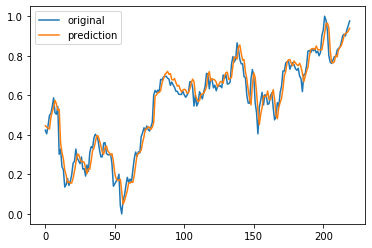

In [15]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

어떻게 이렇게 정확하지?? ! 이미 우리는 결과 값을 알기 때문에,,,
더 정확하게 하기 위해선

- Use more features to improve robustness 뉴스나, 이런것들도 크롤링해서,,